# APP2 : solution

On propose dans ce notebook une solution brève à l'APP2 du cours LEPL1101 d'algèbre linéaire. Ce fichier a pour but de montrer comment de telles régressions sont calculées en pratique (ici, dans le langage de programmation Julia). Pour une solution complète, on réfère les étudiants et tuteurs au fichier PDF contenant les solutions complètes. 

Pour rappel, on nous donne des données $T(t)$, pour $t = 1850, 1851, \dots, 2015$.

Dans un premier temps, on importe le fichier CSV dans lequel ces données sont encodées.

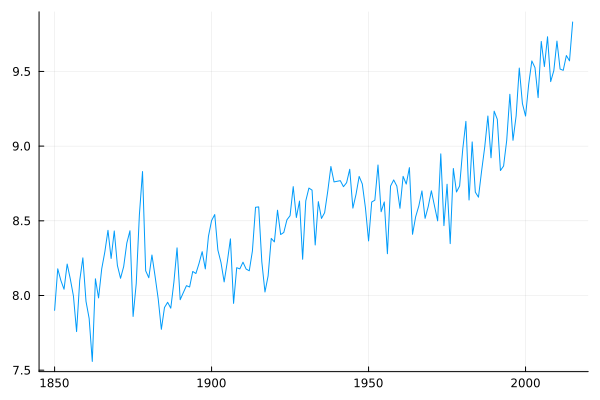

In [1]:
using DataFrames
using CSV
df = CSV.read("data/temperatures.csv", DataFrame)

using Plots
p = plot(df.year, df.temp; legend = false)
display(p)

**1) Modèle de prédiction linéaire**

Pour rappel, on cherche à trouver le meilleur **modèle de prédiction linéaire**, donc de la forme 

$$ \hat{T}_1(t) = \alpha + \beta t. $$

Pour cela, écrivons tout d'abord tout ce que nous savons. Par exemple, pour l'année $1850$, nous cherchons $\alpha$ et $\beta$ tels que 

$$ \alpha + 1850 \beta = T(1850) $$

Si on écrit ces équations pour les données correspondant à toutes les années suivantes, et qu'on écrit cela sous forme matricielle, on obtient

$$
\begin{pmatrix}
    1 & 1850 \\
    1 & 1851 \\
    \vdots & \vdots \\
    1 & 2015
\end{pmatrix}
\begin{pmatrix}
    \alpha \\ 
    \beta
\end{pmatrix}
= 
\begin{pmatrix}
    T(1850) \\
    T(1851) \\
    \vdots \\
    T(2015)
\end{pmatrix}.
$$

Pour faciliter les notations, on ré-écrit 
$$ A := \begin{pmatrix}
    1 & 1850 \\
    1 & 1851 \\
    \vdots & \vdots \\
    1 & 2015
\end{pmatrix}, 
\quad
x := \begin{pmatrix}
    \alpha \\ 
    \beta
\end{pmatrix}, 
\quad
b := \begin{pmatrix}
    T(1850) \\
    T(1851) \\
    \vdots \\
    T(2015)
\end{pmatrix}.
$$

Encodons maintenant la matrice $A$ et le vecteur $b$ en Julia.

In [2]:
A = zeros((length(df.year), 2))
for (i, y) ∈ enumerate(df.year)
    A[i, 1] = 1
    A[i, 2] = y
end
b = df.temp 

print(size(A))
print(size(b))

(166, 2)(166,)

On doit donc résoudre un système linéaire $Ax = b$, où $A \in \mathbb{R}^{166 \times 2}$, $x \in \mathbb{R}^{2}$, et $b \in \mathbb{R}^{166}$.

**Pourquoi ne pouvons-nous pas directement résoudre le système ?**

Ce système a en fait plus d'équations que d'inconnues, ce qui en fait un système **surdéterminé**. Ce genre de système n'admet de solution que si $b \in \mathcal{C}(A)$, ce qui est rarement le cas avec de vraies données (pour comprendre cela, il peut être intéressant de se pencher sur un système linéaire avec 3 équations et 2 inconnues, voir correctif). Typiquement dans cet exemple, $b \notin \mathcal{C}(A)$, et donc il n'y a pas de $\alpha, \beta$ qui satisfait l'équation ci-dessus.

**Comment faire alors ?**

On va utiliser la notion de **projection orthogonale**. Essayons de trouver le vecteur $\hat{b}$ tel que celui-ci est la projection orthogonale du vecteur $b$ dans l'espace $\mathcal{C}(A)$, c'est-à-dire $\hat{b} = P_{\mathcal{C}(A)}(b)$. Ce vecteur sera ensuite égal à 
$$
\hat{b} 
= 
\begin{pmatrix}
    \hat{T}_1(1850) \\
    \hat{T}_1(1851) \\
    \vdots \\
    \hat{T}_1(2015) \\
\end{pmatrix}.
$$

La dérivation de la formule de la projection sur le $\mathcal{C}(A)$ est laissée en exercice (ou, voir correctif), la solution est 
$$ \hat{b} = P_{\mathcal{C}(A)}(b) = A(A^\top A)^{-1} A^\top b.$$

Pour des raisons pratiques/numériques, en Julia, pour trouver $\hat{b}$, on résoud le système $(A^\top A) \hat{x} = A^\top b$, et ensuite on calcule $\hat{b} = A\hat{x}$.

In [3]:
A_proj = transpose(A) * A
b_proj = transpose(A) * b

x_hat = A_proj \ b_proj
b_hat = A * x_hat

166-element Vector{Float64}:
 7.867729673183713
 7.876261226615733
 7.884792780047752
 7.893324333479771
 7.9018558869117905
 7.9103874403438095
 7.918918993775828
 7.927450547207848
 7.935982100639867
 7.944513654071886
 ⋮
 9.207183562010734
 9.215715115442753
 9.224246668874773
 9.232778222306791
 9.241309775738811
 9.249841329170831
 9.258372882602849
 9.266904436034869
 9.275435989466889

On peut maintenant visualiser notre approximation.

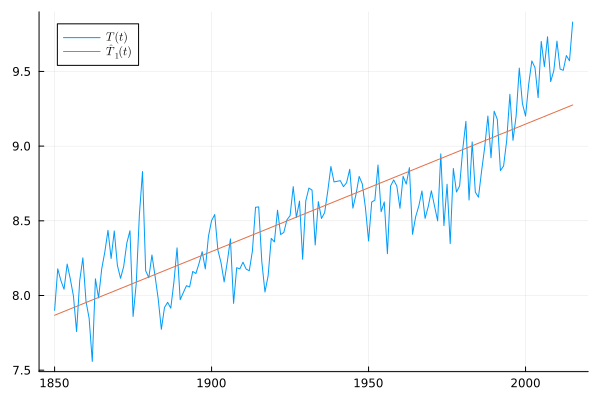

In [4]:
p = plot(df.year, df.temp; label = "\$T(t)\$")
plot!(p, df.year, b_hat; label = "\$\\hat{T}_1(t)\$")
display(p)

**2) Modèle de prédiction quadratique**

On cherche maintenant à trouver le meilleur **modèle de prédiction quadratique**, donc de la forme

$$ \hat{T}_2(t) = \alpha + \beta t + \gamma t^2. $$

Pour cela, écrivons tout d'abord tout ce que nous savons. Par exemple, pour l'année $1850$, nous cherchons $\alpha$, $\beta$ et $\gamma$ tels que 

$$ \alpha + 1850 \beta + (1850)^2 \gamma = T(1850) $$

Si on écrit ces équations pour les données correspondant à toutes les années suivantes, et qu'on écrit cela sous forme matricielle, on obtient

$$
\begin{pmatrix}
    1 & 1850 & (1850)^2 \\
    1 & 1851 & (1851)^2 \\
    \vdots & \vdots & \vdots \\
    1 & 2015 & (2015)^2
\end{pmatrix}
\begin{pmatrix}
    \alpha \\ 
    \beta \\
    \gamma
\end{pmatrix}
= 
\begin{pmatrix}
    T(1850) \\
    T(1851) \\
    \vdots \\
    T(2015)
\end{pmatrix}.
$$

Pour faciliter les notations, on ré-écrit 
$$ A := \begin{pmatrix}
    1 & 1850 & (1850)^2 \\
    1 & 1851 & (1851)^2 \\
    \vdots & \vdots & \vdots \\
    1 & 2015 & (2015)^2
\end{pmatrix}, 
\quad
x := \begin{pmatrix}
    \alpha \\ 
    \beta \\
    \gamma
\end{pmatrix}, 
\quad
b := \begin{pmatrix}
    T(1850) \\
    T(1851) \\
    \vdots \\
    T(2015)
\end{pmatrix}.
$$

On invite les étudiants à comparer ces matrices avec celles définies dans le cas linéaire ci-dessus. On applique maintenant la même méthode : 
- On approxime le système sur-déterminé $Ax = b$, avec $A \in \mathbb{R}^{166 \times 3}$, $x \in \mathbb{R}^{3}$, et $b \in \mathbb{R}^{166}$. 
- On calcule $\hat{b} = P_{\mathcal{C}(A)}(b) = A(A^\top A)^{-1}A^\top b$.

Allons-y en Julia.

In [5]:
A_2 = zeros((length(df.year), 3))
for (i, y) ∈ enumerate(df.year)
    A_2[i, 1] = 1
    A_2[i, 2] = y
    A_2[i, 3] = y * y
end

A_proj_2 = transpose(A_2) * A_2
b_proj_2 = transpose(A_2) * b

x_hat_2 = A_proj_2 \ b_proj_2
b_hat_2 = A_2 * x_hat_2

166-element Vector{Float64}:
 8.11246602150219
 8.112098071359066
 8.111838651747318
 8.111687762667001
 8.11164540411809
 8.111711576100554
 8.111886278614449
 8.11216951165972
 8.112561275236423
 8.11306156934453
 ⋮
 9.38376273660256
 9.400434079889823
 9.417213953708519
 9.434102358058619
 9.451099292940093
 9.468204758353
 9.485418754297312
 9.502741280772998
 9.520172337780117

On peut maintenant de nouveau visualiser le résultat, et comparer à l'approximation linéaire.

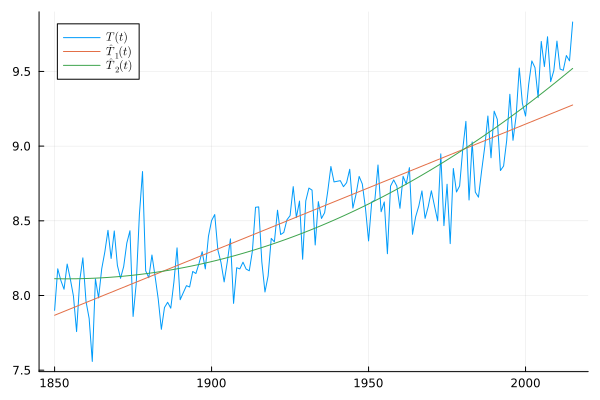

In [6]:
plot!(p, df.year, b_hat_2; label = "\$\\hat{T}_2(t)\$")
display(p)

On peut maintenant calculer l'erreur quadratique
$$
    \sqrt{\sum_{t = 1850}^{2015} \left(\hat{T}_1(t) - T(t)\right)^2}, 
$$
et même chose pour $\hat{T}_2(t)$.

On peut aussi considérer deux modèles, un linéaire et un quadratique légèrement différents de ceux qui ont été trouvés par régression. On les appelle
$$
    \hat{T}_1'(t) = \alpha' + \beta' t \quad \text{et} \quad \hat{T}_2'(t) = \alpha' + \beta' t + \gamma' t^2, 
$$
et également calculer l'erreur quadratique liée à ces modèles.

On définit d'abord une fonction qui permet de calculer l'erreur quadratique pour un modèle.

In [7]:
E_quad(b_model) = sqrt(sum((b_model .- b).^2))

E_quad (generic function with 1 method)

Ensuite, on définit ces modèles $\hat{T}'_1$ et $\hat{T}'_2$. Pour cela, on considère des coefficients légèrement différents de ceux trouvés ci-dessus.

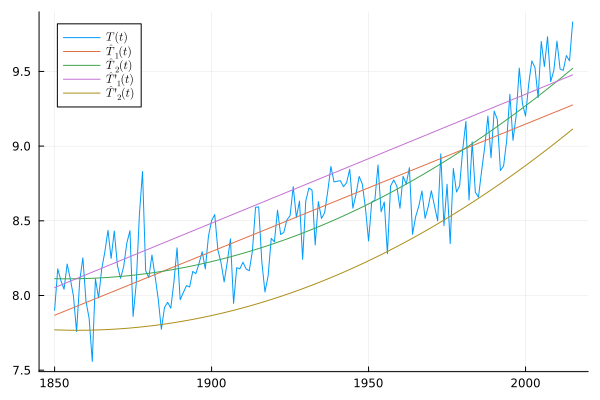

In [8]:
x_hat_prime = x_hat .+ 1e-4
x_hat_2_prime = x_hat_2 .- 1e-7
b_hat_prime = A * x_hat_prime
b_hat_2_prime = A_2 * x_hat_2_prime

plot!(p, df.year, b_hat_prime; label = "\$\\hat{T}'_1(t)\$")
plot!(p, df.year, b_hat_2_prime; label = "\$\\hat{T}'_2(t)\$")
display(p)

On calcule maintenant les erreurs.

In [9]:
E_quad_lin = E_quad(b_hat)
E_quad_quad = E_quad(b_hat_2)
E_quad_lin_prime = E_quad(b_hat_prime)
E_quad_quad_prime = E_quad(b_hat_2_prime)

println("Erreur quadratique - modèle linéaire : $E_quad_lin")
println("Erreur quadratique - modèle quadratique : $E_quad_quad")
println("Erreur quadratique - modèle linéaire perturbé : $E_quad_lin_prime")
println("Erreur quadratique - modèle quadratique perturbé : $E_quad_quad_prime")

Erreur quadratique - modèle linéaire : 3.0459264553721503
Erreur quadratique - modèle quadratique : 2.6862487325655535
Erreur quadratique - modèle linéaire perturbé : 3.9353857093728255
Erreur quadratique - modèle quadratique perturbé : 5.520620828078443


On remarque bien que l'erreur liée au modèle linéaire trouvé par regression est plus petite que celle liée au modèle perturbé. Même observation pour le modèle quadratique. C'est parce que la projection que nous faisons ci-dessus minimise la **distance euclidienne** entre l'espace $\mathcal{C}(A)$ et $b$. Pour rappel, la distance euclidienne entre deux vecteurs $x$ et $y$ de $\mathbb{R}^n$ peut s'écrire
$$ 
    d(x, y) = \|x-y\|_2 = \sqrt{\sum_{i = 1}^n (x_i - y_i)^2 }.
$$
Donc, le modèle trouvé est le modèle qui **minimise l'erreur quadratique**. C'est donc normal que n'importe quel autre modèle ait une erreur plus élevée. 

De plus, on remarque que l'erreur quadratique du modèle quadratique est plus petite que celle du modèle linéaire. **Ce sera toujours le cas**, car le problème quadratique est une **relaxation** du problème linéaire. En effet, un modèle linéaire peut aussi être vu comme un modèle quadratique dans lequel le coefficient de $x^2$ est nul. Si le modèle linéaire était meilleur que le modèle quadratique pour minimiser la distance euclidienne entre $b$ et $\mathcal{C}(A)$, alors le meilleur modèle quadratique trouvé serait le modèle tel que les coefficients en $1$ et $x$ sont les mêmes que le modèle linéaire, et tel que le coefficient en $x^2$ est nul. Autrement dit, ce serait la droite, et l'erreur serait la même. **L'erreur du modèle quadratique ne peut alors être que meilleur ou égal**.